<a href="https://colab.research.google.com/github/iremsinmaz/source/blob/main/flux/finetuning_notebooks_flux_lora_dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

📌 **This notebook has been updated in [jhj0517/finetuning-notebooks](https://github.com/jhj0517/finetuning-notebooks) repository!**

## Version : 1.0.6
---

In [ ]:
#@title #(Optional) Check GPU

#@markdown To train Flux LoRA, at least 32GB VRAM (A100 in Colab) is recommended.
#@markdown <br>You can check your GPU setup before start.
!nvidia-smi

In [ ]:
#@title #1. Install Dependencies
#@markdown This notebook is powered by https://github.com/ostris/ai-toolkit
#@markdown <br>You can ignore the "Restart session" popup after you run the cell.
!git clone -b fix/numpy-error https://github.com/jhj0517/ai-toolkit.git
%cd ai-toolkit
!git submodule update --init --recursive
!pip install -r requirements.txt

# To fix numpy incompatibility from https://github.com/ostris/ai-toolkit/issues/267
import os
!pip install --quiet --force-reinstall --no-deps numpy==1.26.3
os.kill(os.getpid(), 9)


In [1]:
#@title # 2. (Optional) Mount Google Drive

#@markdown It's not mandatory but it's recommended to mount to Google Drive and use the Google Drive's path for your training image dataset.

#@markdown The dataset should have following structure:

#@markdown Each image file should have a corresponding text file (`.txt`) with the same name.
#@markdown The text file contains prompts associated with the image.

#@markdown ### Example File Structure:
#@markdown ```
#@markdown your-dataset/
#@markdown ├── a (1).png         # Image file
#@markdown ├── a (1).txt         # Corresponding prompt for a (1).png
#@markdown ├── a (2).png         # Another image file
#@markdown ├── a (2).txt         # Corresponding prompt for a (2).png
#@markdown ```

from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title # 3. (Optional) Register Huggingface Token To Download Base Model

#@markdown If you don't have entire base model files ([black-forest-labs/FLUX.1-dev](https://huggingface.co/black-forest-labs/FLUX.1-dev)) in the drive you need to sign in to Huggingface to download the model.

#@markdown Get your tokens from https://huggingface.co/settings/tokens, and register it in colab's seceret as **`HF_TOKEN`** and use it in any notebook. ( 'Read' permission is enough )

#@markdown To register secrets in colab, click on the key-shaped icon in the left panel and enter your **`HF_TOKEN`** like this:

#@markdown ![image](https://media.githubusercontent.com/media/jhj0517/finetuning-notebooks/master/docs/screenshots/colab_secrets.png)

import getpass
import os
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')
os.environ['HF_TOKEN'] = hf_token

print("HF_TOKEN environment variable has been set.")

HF_TOKEN environment variable has been set.


In [ ]:
#@title # 4. Train with Parameters
import os
import sys
sys.path.append('/content/ai-toolkit')
from toolkit.job import run_job
from collections import OrderedDict
from PIL import Image
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

#@markdown ## Paths Configuration

#@markdown Set your dataset path and output path for lora here.
DATASET_DIR = "/content/drive/MyDrive/finetuning-notebooks/dataset/dog" # @param {type:"string"}
OUTPUT_DIR = '/content/drive/MyDrive/finetuning-notebooks/flux/outputs'  # @param {type:"string"}
LORA_NAME = 'Your-Lora-v1'  # @param {type:"string"}
os.makedirs(OUTPUT_DIR, exist_ok=True)

#@markdown ## Base Model Configuration
#@markdown If you'll just use the default repo id here then you need to register huggingface token in the previous section
repo_id_or_path = 'black-forest-labs/FLUX.1-dev' # @param {type:"string"}
quantize = False # @param {type:"boolean"}

#@markdown ## Process Settings
#@markdown (max_step_saves_to_keep = how many checkpoints to keep during training. )
dtype = "float16" # @param {type:"string"}
save_every = 250 # @param {type:"number"}
max_step_saves_to_keep = 10 # @param {type:"number"}
#@markdown Whenever `sample_every` step, it will make samples to the output directory with prompts below to benchmark your result.
#@markdown <br>Below is the example with the trigger word "A teddy dog". The "trigger word" thing is not necessary.
sample_every = 250 # @param {type:"number"}
sample_seed = 77 # @param {type: "number"}
sample_steps = 20 # @param {type: "number"}
sample_prompt_1 = "A teddy dog is looking above in bedroom" # @param {type: "string"}
sample_prompt_2 = "A teddy dog is playing with balls on the grass in sunny day" # @param {type: "string"}
sample_prompt_3 = "A teddy dog is sleeping on the caution, the room is dark without light at night" # @param {type: "string"}
### Add `sample_prompts` as much as you need  ###
sample_prompts = [sample_prompt_1, sample_prompt_2, sample_prompt_3]

performance_log_every = 1000 # @param {type:"number"}
#@markdown ### Network
#@markdown You can train only specific layers, `only_if_contains` is enabled when `train_only_specific_layers` is True..
linear = 16 # @param {type:"number"}
linear_alpha = 16 # @param {type:"number"}
## network_kwargs
train_only_specific_layers = False # @param {type:"boolean"}
only_if_contains = ["transformer.single_transformer_blocks.7.proj_out", "transformer.single_transformer_blocks.20.proj_out"] # @param {type: "raw"}

#@markdown ## Dataset Settings
caption_ext = "txt" # @param {type:"string"}
caption_dropout_rate = 0.05 # @param {type:"number"}
shuffle_tokens = False # @param {type:"boolean"}
cache_latents_to_disk = True # @param {type:"boolean"}
resolution = "512, 768, 1024" # @param {type:"string"}
resolution = [int(res.strip()) for res in resolution.split(",")]

#@markdown ## Training Settings
batch_size = 1 # @param {type:"number"}
# Recommended range is 500 ~ 4000
steps = 4000 # @param {type:"number"}
gradient_accumulation_steps = 1 # @param {type:"number"}
train_dtype = "bf16" # @param {type:"string"}
lr = 4e-4 # @param {type:"number"}
train_unet = True # @param {type:"boolean"}
train_text_encoder = False # @param {type:"boolean"}
content_or_style = 'balanced' # @param ["content", "style", "balanced"]
gradient_checkpointing = True # @param {type:"boolean"}
noise_scheduler = 'flowmatch' # @param {type:"string"}
optimizer = 'adamw8bit' # @param {type:"string"}
# ema settings
use_ema = True # @param {type:"boolean"}
ema_decay = 0.99 # @param {type:"number"}

# Training
job_to_run = OrderedDict([
    ('job', 'extension'),
    ('config', OrderedDict([
        # this name will be the folder and filename name
        ('name', LORA_NAME),
        ('process', [
            OrderedDict([
                ('type', 'sd_trainer'),
                ('training_folder', OUTPUT_DIR),
                ('performance_log_every', 1000),
                ('device', 'cuda:0'),
                ('network', OrderedDict([
                    ('type', 'lora'),
                    ('linear', linear),
                    ('linear_alpha', linear_alpha)
                ])),
                ('save', OrderedDict([
                    ('dtype', dtype),
                    ('save_every', save_every),
                    ('max_step_saves_to_keep', max_step_saves_to_keep)
                ])),
                ('datasets', [
                    OrderedDict([
                        ('folder_path', DATASET_DIR),
                        ('caption_ext', caption_ext),
                        ('caption_dropout_rate', caption_dropout_rate),
                        ('shuffle_tokens', shuffle_tokens),
                        ('cache_latents_to_disk', cache_latents_to_disk),
                        ('resolution', resolution)
                    ])
                ]),
                ('train', OrderedDict([
                    ('batch_size', batch_size),
                    ('steps', steps),
                    ('gradient_accumulation_steps', gradient_accumulation_steps),
                    ('train_unet', train_unet),
                    ('train_text_encoder', train_text_encoder),
                    ('content_or_style', content_or_style),
                    ('gradient_checkpointing', gradient_checkpointing),
                    ('noise_scheduler', noise_scheduler),
                    ('optimizer', optimizer),
                    ('lr', lr),
                    ('ema_config', OrderedDict([
                        ('use_ema', use_ema),
                        ('ema_decay', ema_decay)
                    ])),
                    ('dtype', train_dtype)
                ])),
                ('model', OrderedDict([
                    ('name_or_path', repo_id_or_path),
                    ('is_flux', True),
                    ('quantize', quantize),
                ])),
                ('sample', OrderedDict([
                    ('sampler', 'flowmatch'),
                    ('sample_every', sample_every),
                    ('width', 1024),
                    ('height', 1024),
                    ('prompts', sample_prompts),
                    ('neg', ''),
                    ('seed', sample_seed),
                    ('walk_seed', True),
                    ('guidance_scale', 4),
                    ('sample_steps', sample_steps)
                ]))
            ])
        ])
    ])),
    ('meta', OrderedDict([
        ('name', '[name]'),
        ('version', '1.0')
    ]))
])

# Conditional Parameters
if train_only_specific_layers:
    network = job_to_run["config"]["process"][0]["network"]
    network_kwargs = network.setdefault("network_kwargs", OrderedDict())
    network_kwargs["only_if_contains"] = only_if_contains

run_job(job_to_run)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/35 [00:00<?, ?it/s]

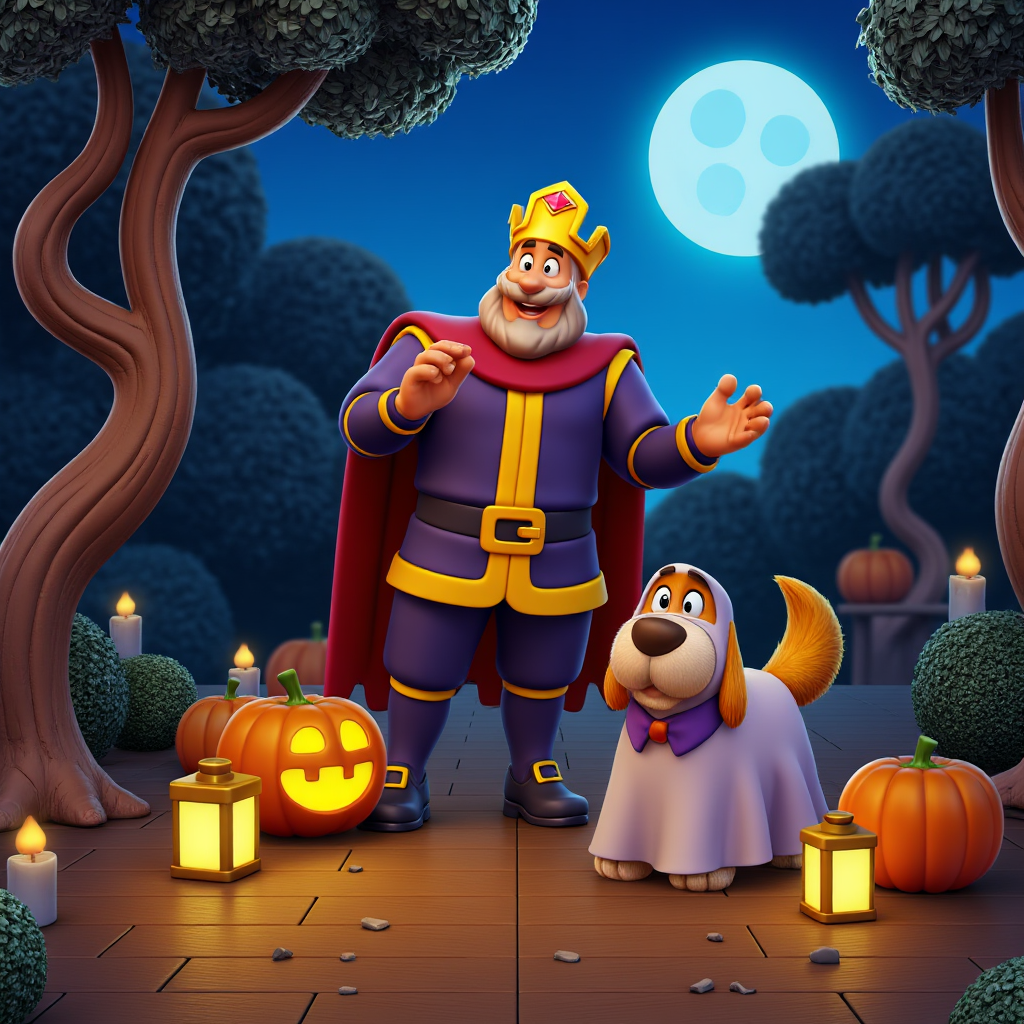

In [1]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
from diffusers import FluxPipeline
import os
from IPython.display import display

# ✅ Ayarlar
BASE_MODEL_REPO_ID_OR_PATH = "black-forest-labs/FLUX.1-dev"  # Temel model
YOUR_LORA_PATH = "/content/drive/MyDrive/finetuning-notebooks/flux/outputs/king_robert/king_robert.safetensors"
LORA_WEIGHT = 0.8  # LoRA etkisi [0.0 - 1.0]

PROMPT = (
    "king in halloween outfit with neutral face in outdoors, "
    "dog in a ghost costume, "
    "spooky twisted trees, cracked pumpkins, candlelit ground, "
    "dust particles, cobwebs, cloudy full moon in sky, dark ambiance, "
    "cinematic 3D cartoon style, warm dark halloween lighting"
)

NEGATIVE_PROMPT = (
    "smiling or cheerful expressions, duplicated characters, symmetrical composition, polished surfaces, "
    "modern furniture, plain or empty backgrounds, flat lighting, overly clean floors, "
    "daylight, bright blue sky, centered framing, text, watermark, blurry, bad anatomy, extra limbs"
)

# ✅ GPU bellek hatalarını azaltmak için
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# ✅ Pipeline oluştur
pipe = FluxPipeline.from_pretrained(BASE_MODEL_REPO_ID_OR_PATH, torch_dtype=torch.bfloat16)
pipe.to("cuda")

# ✅ LoRA yükle ve ağırlığını ayarla
pipe.load_lora_weights(YOUR_LORA_PATH, adapter_name="lora_adapter")
pipe.set_adapters(["lora_adapter"], adapter_weights=[LORA_WEIGHT])

# ✅ Görsel üret
image = pipe(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    guidance_scale=5.5,  # CFG 4
    height=1024,
    width=1024,
    num_inference_steps=35,
    max_sequence_length=256,
).images[0]

# ✅ Görseli kaydet ve göster
image.save("king_output.png")
display(image)
